In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

Mounted at /content/gdrive


In [6]:
PATH = '/content/gdrive/My Drive/data/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    gray_clean = tf.identity(image)
    color= tf.identity(image)
    
    gray_clean = tf.cast(gray_clean, tf.float32)
    color = tf.cast(color, tf.float32)
    
    # convert to gray
    gray_clean = tf.image.rgb_to_grayscale(gray_clean)
    
    # make input
    noise = tf.identity(gray_clean)

    noise_level = 25.0
    n = tf.random.normal((IMG_HEIGHT, IMG_WIDTH, 1))*noise_level    
    noise = noise + n
    noise = tf.clip_by_value(noise, clip_value_min=0, clip_value_max=255)

    return noise, color

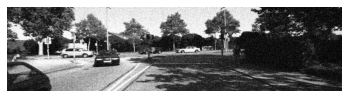

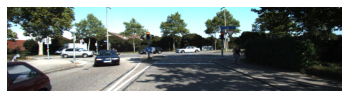

In [7]:
input, target = load(PATH+'unet/kitti_train/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(input[:,:,0]/255.0, cmap='gray')

plt.figure()
plt.axis('off')
plt.imshow(target/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_img, target_img):
    input_img  = (input_img / 127.5) - 1
    target_img = (target_img / 127.5) - 1

    return input_img, target_img

def random_jitter(input_img, target_img):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_img  = tf.image.flip_left_right(input_img)
        target_img = tf.image.flip_left_right(target_img)

    return input_img, target_img

def load_image_train(image_file):
    input_img, target_img = load(image_file)
    input_img, target_img = random_jitter(input_img, target_img)
    #input_img, target_img = normalize(input_img, target_img)

    return input_img, target_img

def load_image_test(image_file):
    input_img, target_img = load(image_file)
    input_img, target_img = normalize(input_img, target_img)

    return input_img, target_img

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
for input_img, target_img in train_dataset:
  print(input_img.shape)
  print(target_img.shape)
  break

(1, 256, 1024, 1)
(1, 256, 1024, 3)


(1, 256, 1024, 1)
(1, 256, 1024, 3)


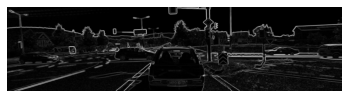

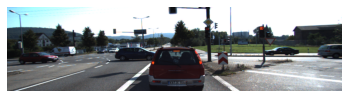

In [ ]:
for input_img, target_img in train_dataset.take(1):
  print(input_img.shape)
  print(target_img.shape)

  plt.figure()
  plt.axis('off')
  plt.imshow(input_img[0,:,:,0]/255.0, cmap='gray')

  plt.figure()
  plt.axis('off')
  plt.imshow(target_img[0]/255.0)